# Forecasting fire frequency with SMLFire1.0

Author: Jatan Buch (v1, 230724) || (v2, 230818) || (v3, 230824) || (v4, 230831) || (v5, 231101) || (v6, 240701)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools
from copy import deepcopy

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray
import xskillscore as xs # for calculating Brier score

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *
from ssf_utils import *

#modules for data processing and gradient boosting 
from ngboost import NGBRegressor, distns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.metrics import mean_squared_error, r2_score
import pickle # for saving and loading models
from pathlib import Path
import shap

#modules for neural network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions

from datetime import datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

## Loading observed and forecast climate predictors

In [2]:
# load in data frame with observed climate, vegetation, and human predictors

target_yr= 2023
rescale_flag= True
if target_yr != 2023:
    clim_df= pd.read_hdf('../data/clim_fire_freq_12km_w2022_rescaled_data.h5')
    sys_no= None
else:
    clim_df= pd.read_hdf('../data/clim_fire_freq_12km_w2023_rescaled_data.h5')
    climdf= deepcopy(clim_df)
    sys_no= 51
clim_df.loc[clim_df[clim_df.fire_freq > 1].index, 'fire_freq']= np.ones(len(clim_df[clim_df.fire_freq > 1].index), dtype= np.int64)

# also load in wildfire_df

wildfire_df= pd.read_hdf('../data/firelist/wildfire_df_wumi2_modis_2023.h5', key= 'df')
wildfire_df['fire_month']= (wildfire_df['final_year']*12 + wildfire_df['final_month']) - (1984*12 + 1) # no. of months since 1984-01

reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW Mts.", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
          15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}

In [3]:
pred_var_arr= ['Tmax', 'Prec', 'VPD', 'Tmin'] #'VPD', 'FFWI',
if target_yr == 'baseline':
    pred_mon_arr= baseline_mon_arr_func(start_yr= 2001, end_yr= 2019, mindx= [5, 6, 7, 8, 9]).values # np.sort(np.append(np.append(np.arange(209, 426, 12), np.arange(210, 427, 12)), np.arange(211, 428, 12))) #2001-2020 
else:
    pred_mon_arr=  np.array([460, 461, 462, 463, 464]) - (2022 - target_yr)*12  #464
firemon_pred_flag= 'dynamical_forecasts' #'dynamical_forecasts' #'observations'
ens_no= 11

X_pred_ur_df, X_pred_test_df= fire_pred_df_func(clim_df, target_yr, pred_mon_arr, pred_var_arr, firemon_pred_flag, sys_no= sys_no, ens_no= ens_no, freq_flag= 'prediction') #freq_flag= 'ensemble' or 'prediction'

100%|██████████| 2/2 [01:30<00:00, 45.05s/it]


## Fire frequency prediction and plotting

### Generating fire frequency predictions

In [4]:
start_year= 1984
end_year= 2019
tot_years= end_year - start_year + 1
start_month= 5 # index of start month with January = 1
tot_months= len(pred_mon_arr)
seas_mon_arr= baseline_mon_arr_func(start_yr= start_year, end_yr= end_year, mindx= np.arange(0, tot_months, 1) + start_month)

freq_id= '08_07_23'
seed= 654
mdn_freq_train_ur_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_ds_%s'%freq_id + '_mon_fire_freq_%s.h5'%seed)
mdn_freq_train_ur_df= mdn_freq_train_ur_df.reset_index().rename(columns= {'index': 'month'})
mdn_freq_train_df= mdn_freq_train_ur_df[mdn_freq_train_ur_df.month.isin(seas_mon_arr)].reset_index(drop= True)

In [5]:
if seed == None:
    mdn_zipd= tf.keras.models.load_model('../sav_files/fire_freq_mods/mdn_ds_%s'%freq_id, custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
else:
    mdn_zipd= tf.keras.models.load_model('../sav_files/fire_freq_mods/mdn_ds_rs_%s'%freq_id + '_%s'%seed, custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
mdn_freq_test_df= grid_ssf_freq_predict(X_test_dat= X_pred_test_df, freq_test_df= X_pred_ur_df.dropna(), n_regs= 18, ml_model= mdn_zipd, func_flag= 'zipd', pred_mon_flag= True, \
                                                                                                                                    pred_mons= pred_mon_arr, loc_flag= False, rseed= 87)
rescale_fac_df= calib_ssf_freq_predict(freq_train_df= mdn_freq_train_df, freq_test_df= mdn_freq_test_df, n_regs= 18, n_train_years= tot_years, n_pred_mons= tot_months, \
                                                                                                                    input_type= 'mean', pred_type= 'mean', regtype= 'linear')
scale_fac= np.array(rescale_fac_df['pred_obs_freq']/rescale_fac_df['pred_freq'])
scale_fac[np.isinf(scale_fac)]= 0
scale_fac[scale_fac < 0]= 0

mdn_freq_test_df['pred_mean_freq']= np.floor(mdn_freq_test_df['pred_mean_freq']*scale_fac)
mdn_freq_test_df['pred_high_2sig']= np.floor(mdn_freq_test_df['pred_high_2sig']*scale_fac)
mdn_freq_test_df['pred_low_2sig']= np.floor(mdn_freq_test_df['pred_low_2sig']*scale_fac)

freq_loc_df= grid_ssf_freq_predict(X_test_dat= X_pred_test_df, freq_test_df= X_pred_ur_df.dropna(), n_regs= 18, ml_model= mdn_zipd, func_flag= 'zipd', pred_mon_flag= True, \
                                                                                                        pred_mons= pred_mon_arr, loc_flag= True, rseed= 87) # df of predicted frequency locations averaged over 1000 samples

# if firemon_pred_flag == 'observations':
#     mdn_freq_test_df.to_hdf('../sav_files/fire_freq_pred_dfs/mdn_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%target_yr + '_%s.h5'%firemon_pred_flag, key= 'df', mode= 'w')
#     freq_loc_df.to_hdf('../sav_files/fire_freq_pred_dfs/freq_loc_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%target_yr + '_%s.h5'%firemon_pred_flag, key= 'df', mode= 'w')
# else:
#     mdn_freq_test_df.to_hdf('../sav_files/fire_freq_pred_dfs/' + '%s'%firemon_pred_flag + '/%s'%target_yr + '/mdn_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%ens_no + '_%d.h5'%target_yr, key= 'df', mode= 'w')
#     freq_loc_df.to_hdf('../sav_files/fire_freq_pred_dfs/' + '%s'%firemon_pred_flag + '/%s'%target_yr + '/freq_loc_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%ens_no + '_%d.h5'%target_yr, key= 'df', mode= 'w')

  0%|          | 0/18 [00:00<?, ?it/s]

19/19 [==============================] - 0s 563us/step


  6%|▌         | 1/18 [00:00<00:11,  1.55it/s]

10/10 [==============================] - 0s 494us/step


 11%|█         | 2/18 [00:00<00:06,  2.33it/s]

17/17 [==============================] - 0s 412us/step


 17%|█▋        | 3/18 [00:01<00:05,  2.67it/s]

8/8 [==============================] - 0s 475us/step


 22%|██▏       | 4/18 [00:01<00:04,  2.99it/s]

37/37 [==============================] - 0s 314us/step


 28%|██▊       | 5/18 [00:01<00:04,  2.83it/s]

19/19 [==============================] - 0s 329us/step


 33%|███▎      | 6/18 [00:02<00:04,  2.98it/s]

22/22 [==============================] - 0s 327us/step


 39%|███▉      | 7/18 [00:02<00:03,  3.05it/s]

65/65 [==============================] - 0s 288us/step


 44%|████▍     | 8/18 [00:02<00:03,  2.73it/s]

42/42 [==============================] - 0s 287us/step


 50%|█████     | 9/18 [00:03<00:03,  2.67it/s]

54/54 [==============================] - 0s 319us/step


 56%|█████▌    | 10/18 [00:03<00:03,  2.58it/s]

33/33 [==============================] - 0s 337us/step


 61%|██████    | 11/18 [00:04<00:02,  2.63it/s]

71/71 [==============================] - 0s 285us/step


 67%|██████▋   | 12/18 [00:04<00:02,  2.41it/s]

68/68 [==============================] - 0s 271us/step


 72%|███████▏  | 13/18 [00:05<00:02,  2.35it/s]

65/65 [==============================] - 0s 275us/step


 78%|███████▊  | 14/18 [00:05<00:01,  2.31it/s]

51/51 [==============================] - 0s 305us/step


 83%|████████▎ | 15/18 [00:05<00:01,  2.36it/s]

62/62 [==============================] - 0s 358us/step


 89%|████████▉ | 16/18 [00:06<00:00,  2.24it/s]

29/29 [==============================] - 0s 303us/step


 94%|█████████▍| 17/18 [00:06<00:00,  2.42it/s]

36/36 [==============================] - 0s 282us/step


  0%|          | 0/18 [00:00<?, ?it/s]

19/19 [==============================] - 0s 323us/step


  6%|▌         | 1/18 [00:00<00:03,  4.76it/s]

10/10 [==============================] - 0s 428us/step


 11%|█         | 2/18 [00:00<00:03,  4.89it/s]

17/17 [==============================] - 0s 326us/step


 17%|█▋        | 3/18 [00:00<00:03,  4.93it/s]

8/8 [==============================] - 0s 475us/step


 22%|██▏       | 4/18 [00:00<00:02,  5.27it/s]

37/37 [==============================] - 0s 285us/step


 28%|██▊       | 5/18 [00:01<00:02,  4.58it/s]

19/19 [==============================] - 0s 356us/step


 33%|███▎      | 6/18 [00:01<00:02,  4.36it/s]

22/22 [==============================] - 0s 352us/step


 39%|███▉      | 7/18 [00:01<00:02,  4.31it/s]

65/65 [==============================] - 0s 318us/step


 44%|████▍     | 8/18 [00:01<00:02,  3.50it/s]

42/42 [==============================] - 0s 287us/step


 50%|█████     | 9/18 [00:02<00:02,  3.42it/s]

54/54 [==============================] - 0s 276us/step


 56%|█████▌    | 10/18 [00:02<00:02,  3.14it/s]

33/33 [==============================] - 0s 291us/step


 61%|██████    | 11/18 [00:02<00:02,  3.33it/s]

71/71 [==============================] - 0s 297us/step


 67%|██████▋   | 12/18 [00:03<00:01,  3.07it/s]

68/68 [==============================] - 0s 288us/step


 72%|███████▏  | 13/18 [00:03<00:01,  2.92it/s]

65/65 [==============================] - 0s 312us/step


 78%|███████▊  | 14/18 [00:04<00:01,  2.80it/s]

51/51 [==============================] - 0s 280us/step


 83%|████████▎ | 15/18 [00:04<00:01,  2.89it/s]

62/62 [==============================] - 0s 318us/step


 89%|████████▉ | 16/18 [00:04<00:00,  2.79it/s]

29/29 [==============================] - 0s 387us/step


 94%|█████████▍| 17/18 [00:05<00:00,  2.89it/s]

36/36 [==============================] - 0s 311us/step


100%|██████████| 18/18 [00:05<00:00,  3.35it/s]


In [6]:
freqlabel= 'pred_mean_freq' # 'pred_mean_freq', 'pred_high_2sig', 'pred_low_2sig'
pred_loc_arr= loc_ind_ssf_func(loc_df= freq_loc_df, ml_freq_df= mdn_freq_test_df, X_test_dat= X_pred_test_df, pred_mon_flag= True, pred_mons= pred_mon_arr, freqlabel= freqlabel)
X_pred_ur_df['pred_fire_freq']= np.zeros_like(X_pred_ur_df['fire_freq'])
for r in tqdm(range(18)):
    X_pred_ur_df.loc[X_pred_ur_df.groupby('reg_indx').get_group(r+1).index, 'pred_fire_freq']= 0

for ind in tqdm(np.hstack(pred_loc_arr)):
    X_pred_ur_df.loc[ind, 'pred_fire_freq']+=1 

nan_ind_arr= X_pred_ur_df['Tmax'].isna()
X_pred_ur_df.loc[nan_ind_arr, 'pred_fire_freq']= np.nan
if firemon_pred_flag == 'observations':
    X_pred_ur_df.to_hdf('../sav_files/ssf_pred_files/%s_dataframe'%freqlabel + '_%s'%freq_id + '_%d'%seed +  '_obs_%d.h5'%target_yr, key= 'df', mode= 'w')
else:
    X_pred_ur_df.to_hdf('../sav_files/ssf_pred_files/' + '%s'%firemon_pred_flag + '/%s'%target_yr + '/%s_dataframe'%freqlabel + '_%s'%freq_id + '_%d'%seed +  '_%d'%ens_no + '_%d.h5'%target_yr, key= 'df', mode= 'w')

100%|██████████| 210/210 [00:00<00:00, 25359.28it/s]


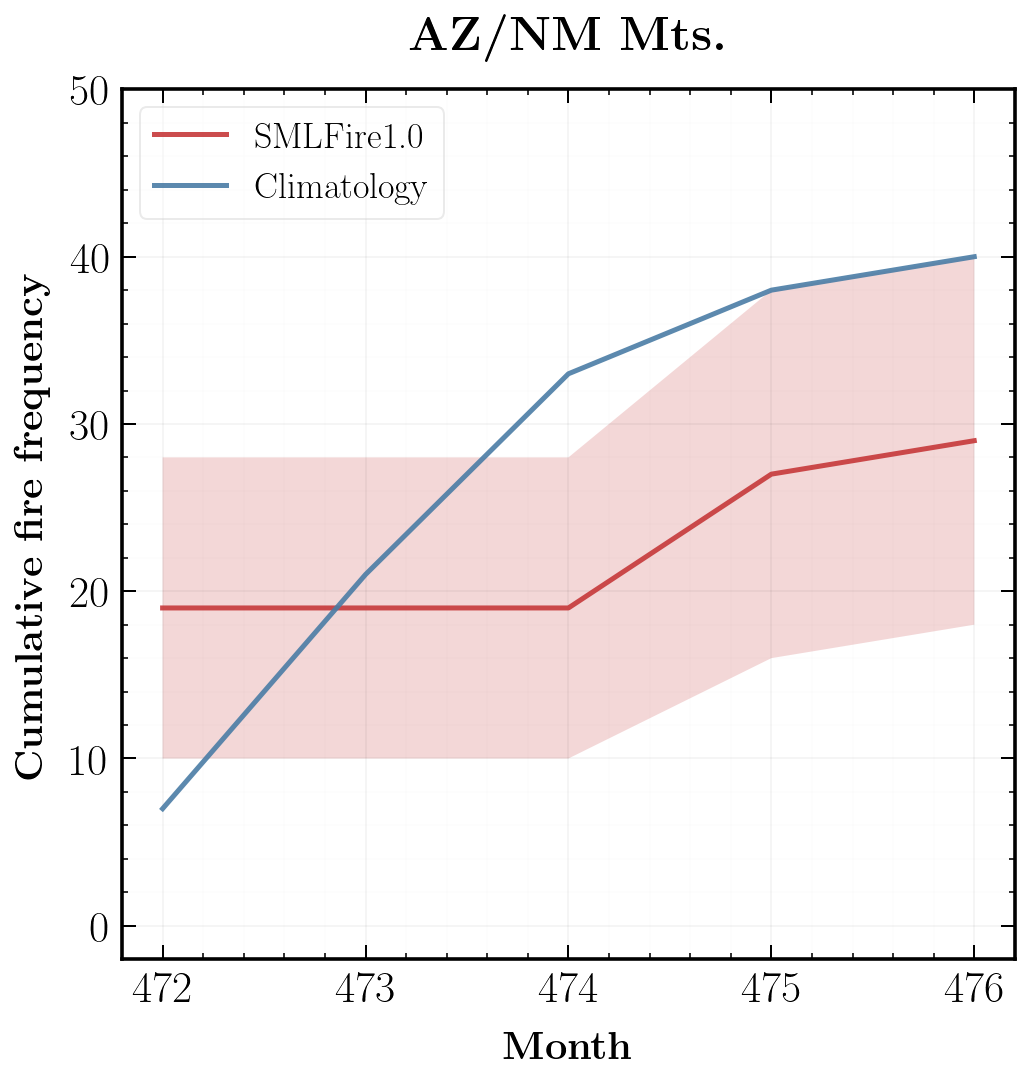

In [7]:
rindx= 11
plt_reg= 'aznmmts'
plot_yr= 2022
fig, ax= plt.subplots(figsize= (8, 8))

pred_ml_fire_freq= np.cumsum(X_pred_ur_df.groupby('reg_indx').get_group(rindx).groupby('month')['pred_fire_freq'].sum())
plt.plot(X_pred_ur_df.groupby('reg_indx').get_group(rindx).month.unique(), pred_ml_fire_freq, label= 'SMLFire1.0', linewidth= 2.5)
plt.fill_between(X_pred_ur_df.groupby('reg_indx').get_group(rindx).month.unique(), pred_ml_fire_freq - np.ceil(2*np.sqrt(pred_ml_fire_freq)), \
                                                                                            pred_ml_fire_freq + np.ceil(2*np.sqrt(pred_ml_fire_freq)), linewidth= 2.5, alpha= 0.2)
plt.plot(X_pred_ur_df.groupby('reg_indx').get_group(rindx).month.unique(), np.cumsum(obs_fire_freq_climatology(fire_freq_df= clim_df, pred_mons= [5, 6, 7, 8, 9], regindx= rindx)), \
                                                                                                                label= 'Climatology', linewidth= 2.5)
#plt.plot(X_pred_ur_df.groupby('reg_indx').get_group(rindx).month.unique(), np.cumsum(X_pred_ur_df.groupby('reg_indx').get_group(rindx).groupby('month')['fire_freq'].sum()), \
#                                                                                                                label= 'Observations', linestyle='--', color='black', linewidth= 3)

ax.set_ylabel(r'{\bf Cumulative fire frequency}', fontsize= 20, labelpad= 10);
ax.set_xlabel(r'{\bf Month}', fontsize= 20, labelpad= 10);
ax.set_ylim(-2, 50)

ax.set_title(r'{\bf %s}'%reg_name[rindx], fontsize= 24, pad= 20);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.legend(loc= 'upper left', frameon= True, fontsize= 18);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/smlfire_output/%s'%firemon_pred_flag + '/pred_fire_freq_%s'%freq_id + '_%d'%seed + '_%d_'%plot_yr + 'df_%d'%ens_no + '_%s.png'%plt_reg, bbox_inches='tight', dpi= 200);

### Ensemble fire frequency plots

In [9]:
freq_id= '08_07_23'
seed= 654
firemon_pred_flag= 'dynamical_forecasts'
ens_no_arr= np.arange(0, 51, 1, dtype= np.int64)

In [10]:
for enp in ens_no_arr:
    freqlabel= 'pred_mean_freq' # 'pred_mean_freq', 'pred_high_2sig', 'pred_low_2sig'
    mdn_freq_test_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/' + '%s'%firemon_pred_flag + '/%s'%target_yr + '/mdn_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%enp \
                                                                                                                                                        + '_%d.h5'%target_yr)
    freq_loc_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/' + '%s'%firemon_pred_flag + '/%s'%target_yr + '/freq_loc_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%enp \
                                                                                                                                                        + '_%d.h5'%target_yr)
    pred_loc_arr= loc_ind_ssf_func(loc_df= freq_loc_df, ml_freq_df= mdn_freq_test_df, X_test_dat= X_pred_test_df, pred_mon_flag= True, pred_mons= pred_mon_arr, freqlabel= freqlabel)

    X_pred_ur_df['pred_fire_freq_%d'%enp]= np.zeros_like(X_pred_ur_df['fire_freq'])
    for r in tqdm(range(18)):
        X_pred_ur_df.loc[X_pred_ur_df.groupby('reg_indx').get_group(r+1).index, 'pred_fire_freq']= 0

    for ind in tqdm(np.hstack(pred_loc_arr)):
        X_pred_ur_df.loc[ind, 'pred_fire_freq_%d'%enp]+=1 

    nan_ind_arr= X_pred_ur_df['Tmax'].isna()
    X_pred_ur_df.loc[nan_ind_arr, 'pred_fire_freq_%d'%enp]= np.nan

X_pred_ur_df['pred_mean_freq']= X_pred_ur_df.iloc[:, 4:].mean(axis= 1)

100%|██████████| 167/167 [00:00<00:00, 18588.42it/s]


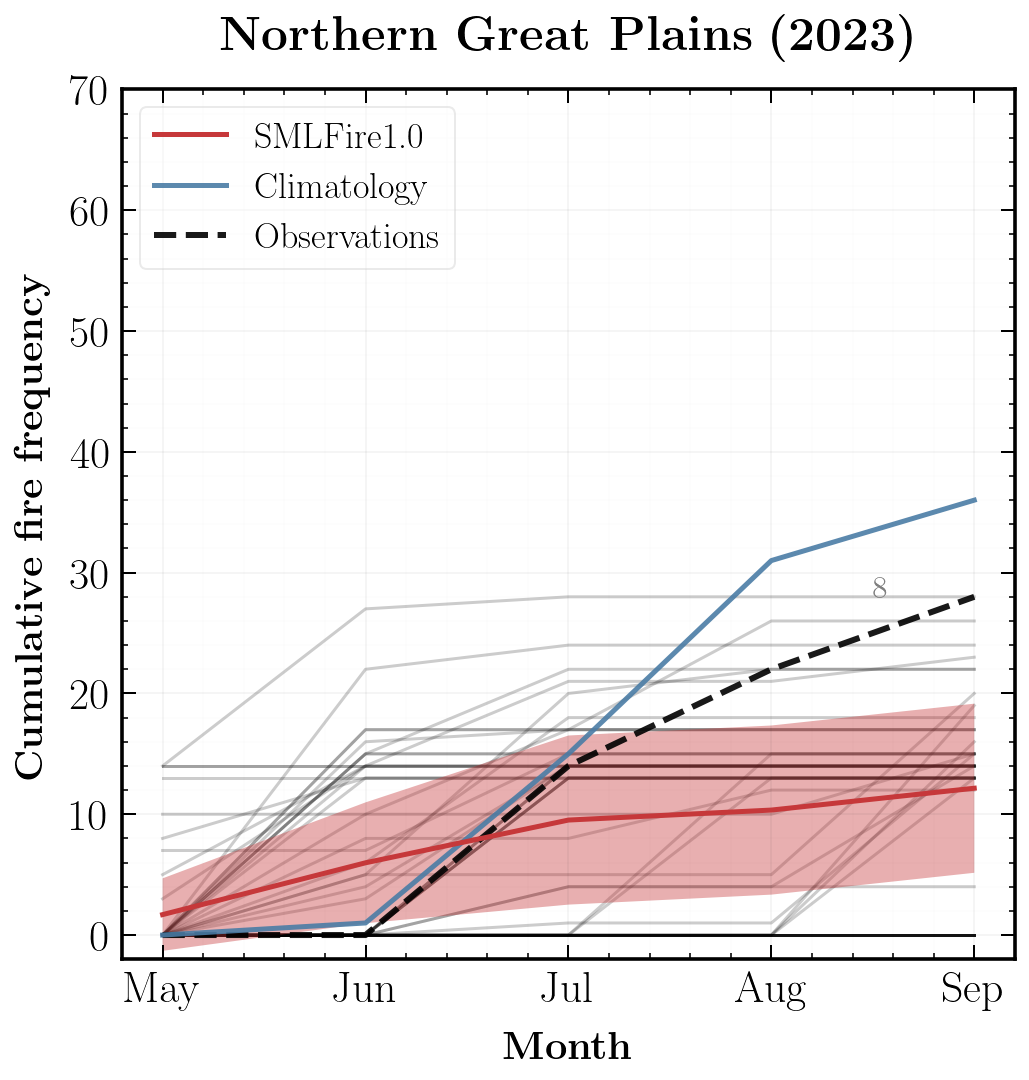

In [41]:
rindx= 14
plt_reg= 'ngplains'
plot_yr= 2023
fig, ax= plt.subplots(figsize= (8, 8))
pred_ml_fire_freq= np.cumsum(X_pred_ur_df.groupby('reg_indx').get_group(rindx).groupby('month')['pred_mean_freq'].sum())
max_ens_no= np.argmax((X_pred_ur_df.groupby('reg_indx').get_group(rindx).groupby('month').sum().sum())[3:]) - 1

#pred_ml_clim_std= np.sqrt(np.cumsum(np.array([np.sqrt(np.sum(X_pred_ur_df.groupby('reg_indx').get_group(rindx).groupby('month')['pred_freq_std'].get_group(m)**2)) for m in pred_mon_arr])**2))
plt.plot(pred_mon_arr, pred_ml_fire_freq.to_numpy(), label= 'SMLFire1.0', linewidth= 2.5, alpha= 1, zorder= 100)
for enp in ens_no_arr:
    plt.plot(pred_mon_arr, np.cumsum(X_pred_ur_df.groupby('reg_indx').get_group(rindx).groupby('month')['pred_fire_freq_%d'%enp].sum()).to_numpy(), \
                                                                                c= 'black', alpha= 0.2, linewidth= 1.5, zorder= 1)
plt.fill_between(pred_mon_arr, (pred_ml_fire_freq - np.ceil(2*np.sqrt(pred_ml_fire_freq))).to_numpy(), \
                                                                                (pred_ml_fire_freq + np.ceil(2*np.sqrt(pred_ml_fire_freq))).to_numpy(), linewidth= 2.5, alpha= 0.4)
#plt.fill_between(X_pred_ur_df.groupby('reg_indx').get_group(rindx).month.unique(), pred_ml_fire_freq - np.floor(2*pred_ml_clim_std), \
#                                                                                pred_ml_fire_freq + np.floor(2*pred_ml_clim_std), linewidth= 2.5, alpha= 0.2, color= 'black')
plt.plot(pred_mon_arr, np.cumsum(obs_fire_freq_climatology(fire_freq_df= clim_df, pred_mons= [5, 6, 7, 8, 9], regindx= rindx)), \
                                                                                                                label= 'Climatology', linewidth= 2.5, zorder= 10)
obs_freq= wildfire_df.groupby('reg_indx').get_group(rindx)[wildfire_df['fire_month'].isin(pred_mon_arr)].groupby('fire_month').size().to_numpy()
plt.plot(pred_mon_arr, np.cumsum([0, 0, 14, 8, 6]), label= 'Observations', linestyle='--', color='black', linewidth= 3)


ax.set_ylabel(r'{\bf Cumulative fire frequency}', fontsize= 20, labelpad= 10);
ax.set_xlabel(r'{\bf Month}', fontsize= 20, labelpad= 10);
ax.set_xticks(pred_mon_arr)
ax.set_xticklabels(['May', 'Jun', 'Jul', 'Aug', 'Sep']);
ax.set_ylim(-2, 70)
ax.text(475.5, (X_pred_ur_df.groupby('reg_indx').get_group(rindx).groupby('month').sum().sum()[3:]).max(), r'%d'%max_ens_no, color= 'gray', fontsize= 16, zorder= 10)

ax.set_title(r'{\bf %s}'%reg_name[rindx] + r' {\bf (%s)}'%plot_yr, fontsize= 24, pad= 20);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.legend(loc= 'upper left', frameon= True, fontsize= 18);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/smlfire_output/%s'%firemon_pred_flag + '/pred_fire_freq_%s'%freq_id + '_%d'%seed + '_%d_'%plot_yr + 'ens_mean_spread' + '_%s.pdf'%plt_reg, bbox_inches='tight', dpi= 300);

In [51]:
(X_pred_ur_df.groupby('reg_indx').get_group(rindx).groupby('month').sum().sum())[3:].sort_values(ascending= False)

pred_fire_freq_8     56.000000
pred_fire_freq_13    52.000000
pred_fire_freq_47    51.000000
pred_fire_freq_20    48.000000
pred_fire_freq_0     46.000000
pred_fire_freq_24    46.000000
pred_fire_freq_10    45.000000
pred_fire_freq_25    45.000000
pred_fire_freq_32    44.000000
pred_fire_freq_37    44.000000
pred_fire_freq_43    43.000000
pred_fire_freq_18    42.000000
pred_fire_freq_6     42.000000
pred_fire_freq_49    42.000000
pred_fire_freq_45    42.000000
pred_fire_freq_16    41.000000
pred_fire_freq_22    40.000000
pred_fire_freq_19    40.000000
pred_fire_freq_2     40.000000
pred_fire_freq_26    40.000000
pred_fire_freq_38    40.000000
pred_fire_freq_33    39.000000
pred_fire_freq_21    39.000000
pred_fire_freq_11    39.000000
pred_fire_freq_9     39.000000
pred_fire_freq_29    39.000000
pred_mean_freq       38.365385
pred_fire_freq_39    38.000000
pred_fire_freq_31    38.000000
pred_fire_freq_1     38.000000
pred_fire_freq_15    38.000000
pred_fire_freq_36    38.000000
pred_fir

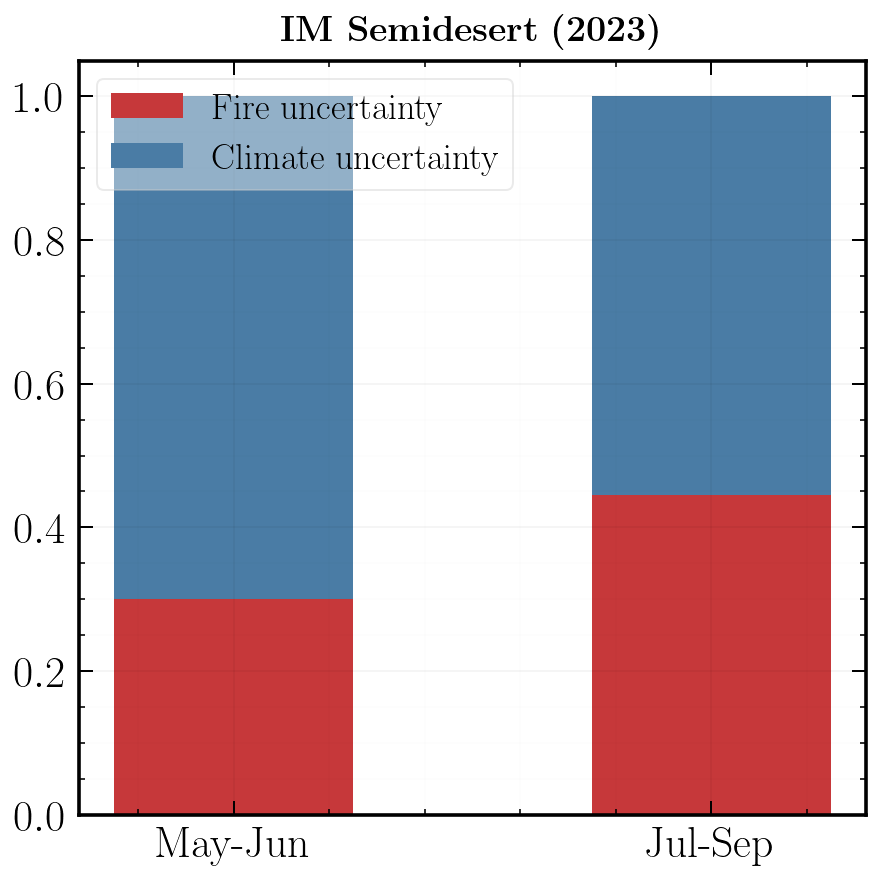

In [43]:
rindx= 12
plt_reg= 'imsemidesert'
plt.rcParams['figure.constrained_layout.use'] = True
fig, ax= plt.subplots(1, 1, figsize=(6, 6), sharey= True)
width = 0.5
species = (
    "May-Jun",
    "Jul-Sep",
)
ens_freq_arr_may= []
ens_freq_arr_jul= []
for enp in ens_no_arr:
    ens_freq_arr_may.append(X_pred_ur_df.groupby('reg_indx').get_group(rindx).groupby('month')['pred_fire_freq_%d'%enp].sum()[472])
    ens_freq_arr_jul.append(X_pred_ur_df.groupby('reg_indx').get_group(rindx).groupby('month')['pred_fire_freq_%d'%enp].sum()[474])
pred_ml_fire_freq= np.cumsum(X_pred_ur_df.groupby('reg_indx').get_group(rindx).groupby('month')['pred_mean_freq'].sum())

norm_fac_1= np.ceil(np.std(ens_freq_arr_may)) + np.ceil(2*np.sqrt(pred_ml_fire_freq)[472])
norm_fac_2= np.ceil(np.std(ens_freq_arr_jul)) + np.ceil(2*np.sqrt(pred_ml_fire_freq)[474])

weight_counts = {
    "Fire uncertainty": np.array([np.ceil(2*np.sqrt(pred_ml_fire_freq)[472])/norm_fac_1, np.ceil(2*np.sqrt(pred_ml_fire_freq)[474])/norm_fac_2]),
    "Climate uncertainty": np.array([np.ceil(np.std(ens_freq_arr_may))/norm_fac_1, np.ceil(np.std(ens_freq_arr_jul))/norm_fac_2]),
    } 

bottom = np.zeros(2)
for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count
        
ax.set_title(r'{\bf %s}'%reg_name[rindx] + r' {\bf (%s)}'%plot_yr, fontsize= 18, pad= 10);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.legend(loc= 'upper left', frameon= True, fontsize= 18);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/smlfire_output/dynamical_forecasts/seas_fire_freq_UQ_%s'%freq_id + '_%s'%plt_reg + '_%d.pdf'%plot_yr, bbox_inches='tight', dpi= 200);

In [47]:
np.ceil(np.std(ens_freq_arr_may))

14.0

In [48]:
np.ceil(2*np.sqrt(pred_ml_fire_freq)[472])

6.0

## Sanity checks

### Spatial frequency map

In [ ]:
pred_freq_xarr= xarray.DataArray(data= X_pred_ur_df['pred_fire_freq'].to_numpy().reshape(len(pred_mon_arr), 208, 155),
        dims=["month", "Y", "X"],
        coords=dict(
            X=(["X"], np.linspace(-2349250, -501250, 155)),
            Y=(["Y"], np.linspace(3166500, 682500, 208)),
            time= (["month"], pred_mon_arr),),)
#pred_freq_xarr.to_netcdf('../sav_files/ssf_pred_files/pred_freq_xarr_rs_%s'%freq_id + '_%d_'%seed + 'obs_%s.nc'%target_yr)

In [ ]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
lat_long_fire_grid= coord_transform(pred_freq_xarr['X'][:].data, pred_freq_xarr['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')
wildfire_plot_yr= wildfire_df[(wildfire_df.final_year== target_yr)&(wildfire_df.final_month >= 6)&(wildfire_df.final_month <= 10)]

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');

CS= ax.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_freq_xarr.sum(axis= 0, skipna= False), cmap=plt.cm.viridis) 
cax= fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.1, ax.get_position().width, 0.02])
cbar= fig.colorbar(CS, cax= cax, orientation= 'horizontal', shrink= 0.7)
ax.scatter(wildfire_plot_yr['final_lon'], wildfire_plot_yr['final_lat'], c= 'white', s= 10, transform=ccrs.PlateCarree())

gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1) 
ax.set_title(r'Predicted fire frequency June - October %s'%target_yr, fontsize= 22);
#plt.savefig('../plots/smlfire_output/pred_fire_freq_%s'%freq_id + '_%d'%seed + '_%d_'%plot_yr + 'obs_wus.png', bbox_inches='tight', dpi= 200);

### Baseline and climate predictor comparison

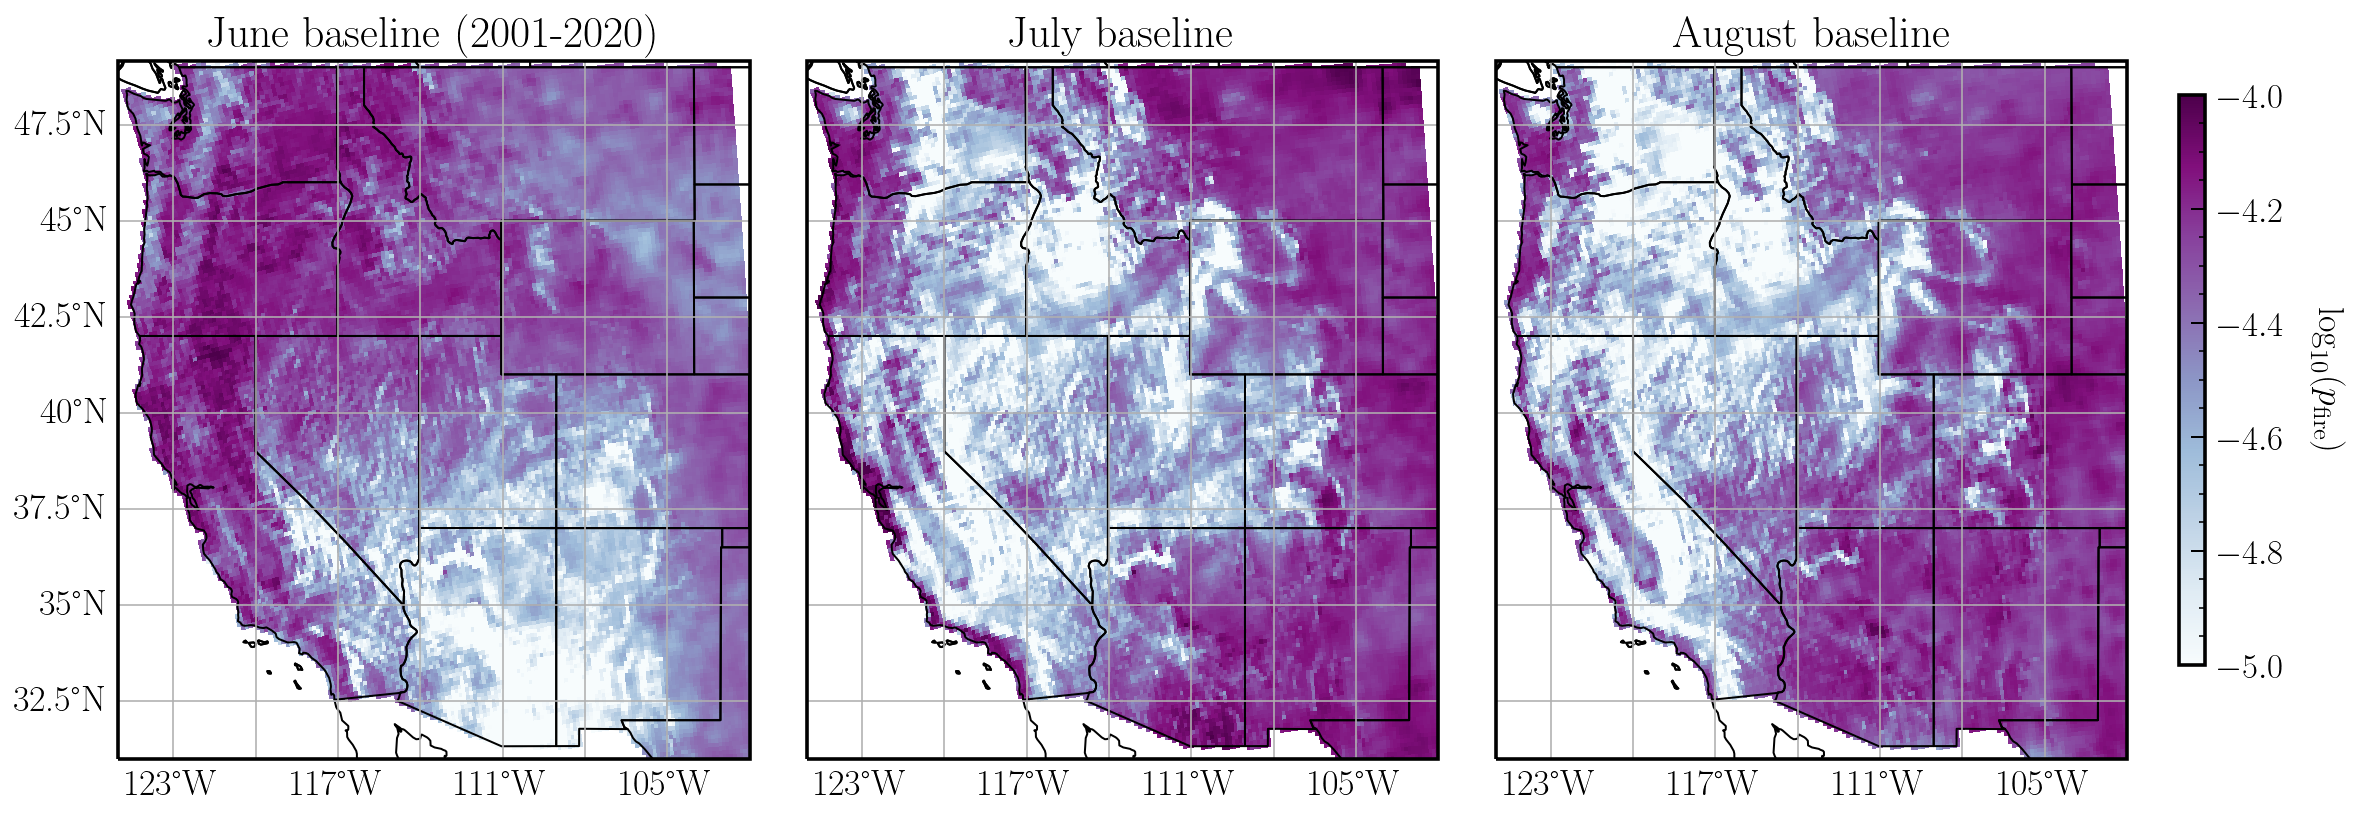

In [ ]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(4, 6)

ax= fig.add_subplot(gs[0:4, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');
CS= ax.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], np.log10(pred_prob_xarr_jun_baseline/np.sum(pred_prob_xarr_jun_baseline)), vmin= -5, vmax= -4, cmap=plt.cm.BuPu) #.mean(axis= 0, skipna= False)  np.log10(pred_prob_xarr[0, : , :])
#cax= fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.1, ax.get_position().width, 0.02])
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1)
ax.set_title(r'June baseline (2001-2020)', fontsize= 22);

ax1= fig.add_subplot(gs[0:4, 2:4], projection=ccrs.PlateCarree())
ax1.set_extent(extent);
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black');
CS1= ax1.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1],np.log10(pred_prob_xarr_jul_baseline/np.sum(pred_prob_xarr_jul_baseline)), vmin= -5, vmax= -4, cmap=plt.cm.BuPu) #.mean(axis= 0, skipna= False)
gl1= ax1.gridlines(draw_labels=True);
gl1.xlabel_style = {'size': 18, 'color': 'black'}
gl1.ylabel_style = {'size': 18, 'color': 'black'}
gl1.top_labels = False
gl1.left_labels = False
gl1.right_labels = False
ax1.set_aspect(1.4/1)
ax1.set_title(r'July baseline', fontsize= 22);

ax2= fig.add_subplot(gs[0:4, 4:6], projection=ccrs.PlateCarree())
ax2.set_extent(extent);
ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax2.add_feature(cfeature.STATES, edgecolor='black');
CS2= ax2.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], np.log10(pred_prob_xarr_aug_baseline/np.sum(pred_prob_xarr_aug_baseline)), vmin= -5, vmax= -4, cmap=plt.cm.BuPu) #.mean(axis= 0, skipna= False)
cax= fig.add_axes([ax2.get_position().x1 + 0.02, ax2.get_position().y1 - 0.35, 0.01, ax2.get_position().height + 0.05])
cbar= fig.colorbar(CS2, cax= cax, orientation= 'vertical')
cbar.set_label(r'${\rm log}_{10}(p_{\rm fire})$ ', labelpad= 30, rotation= 270, fontsize= 18)
gl2= ax2.gridlines(draw_labels=True);
gl2.xlabel_style = {'size': 18, 'color': 'black'}
gl2.ylabel_style = {'size': 18, 'color': 'black'}
gl2.top_labels = False
gl2.left_labels = False
gl2.right_labels = False
ax2.set_aspect(1.4/1)
ax2.set_title(r'August baseline', fontsize= 22);
#plt.savefig('../plots/smlfire_output/pred_fire_prob_rs_obs_baseline.png', bbox_inches='tight', dpi= 200);

In [ ]:
vpd_xarr= xarray.open_dataarray('../data/12km/climate/primary/vpd.nc').sel(time= slice('1984-01-15', '2023-05-15'))
tmax_xarr= xarray.open_dataarray('../data/12km/climate/primary/tmax.nc').sel(time= slice('1984-01-15', '2023-05-15'))
prec_xarr= xarray.open_dataarray('../data/12km/climate/primary/prec.nc').sel(time= slice('1984-01-15', '2023-05-15'))
ffwi_xarr= xarray.open_dataarray('../data/12km/climate/primary/ffwi.nc').sel(time= slice('1984-01-15', '2023-05-15'))

# antprec_xarr= xarray.DataArray(data= X_pred_ur_df['Avgprec_3mo'].to_numpy().reshape(3, 208, 155),
#         dims=["month", "Y", "X"],
#         coords=dict(
#             X=(["X"], np.linspace(-2349250, -501250, 155)),
#             Y=(["Y"], np.linspace(3166500, 682500, 208)),
#             time= (["month"], np.linspace(0, 2, 3, dtype= np.int64)),),)
lat_long_grid= coord_transform(ffwi_xarr['X'][:].data, ffwi_xarr['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')

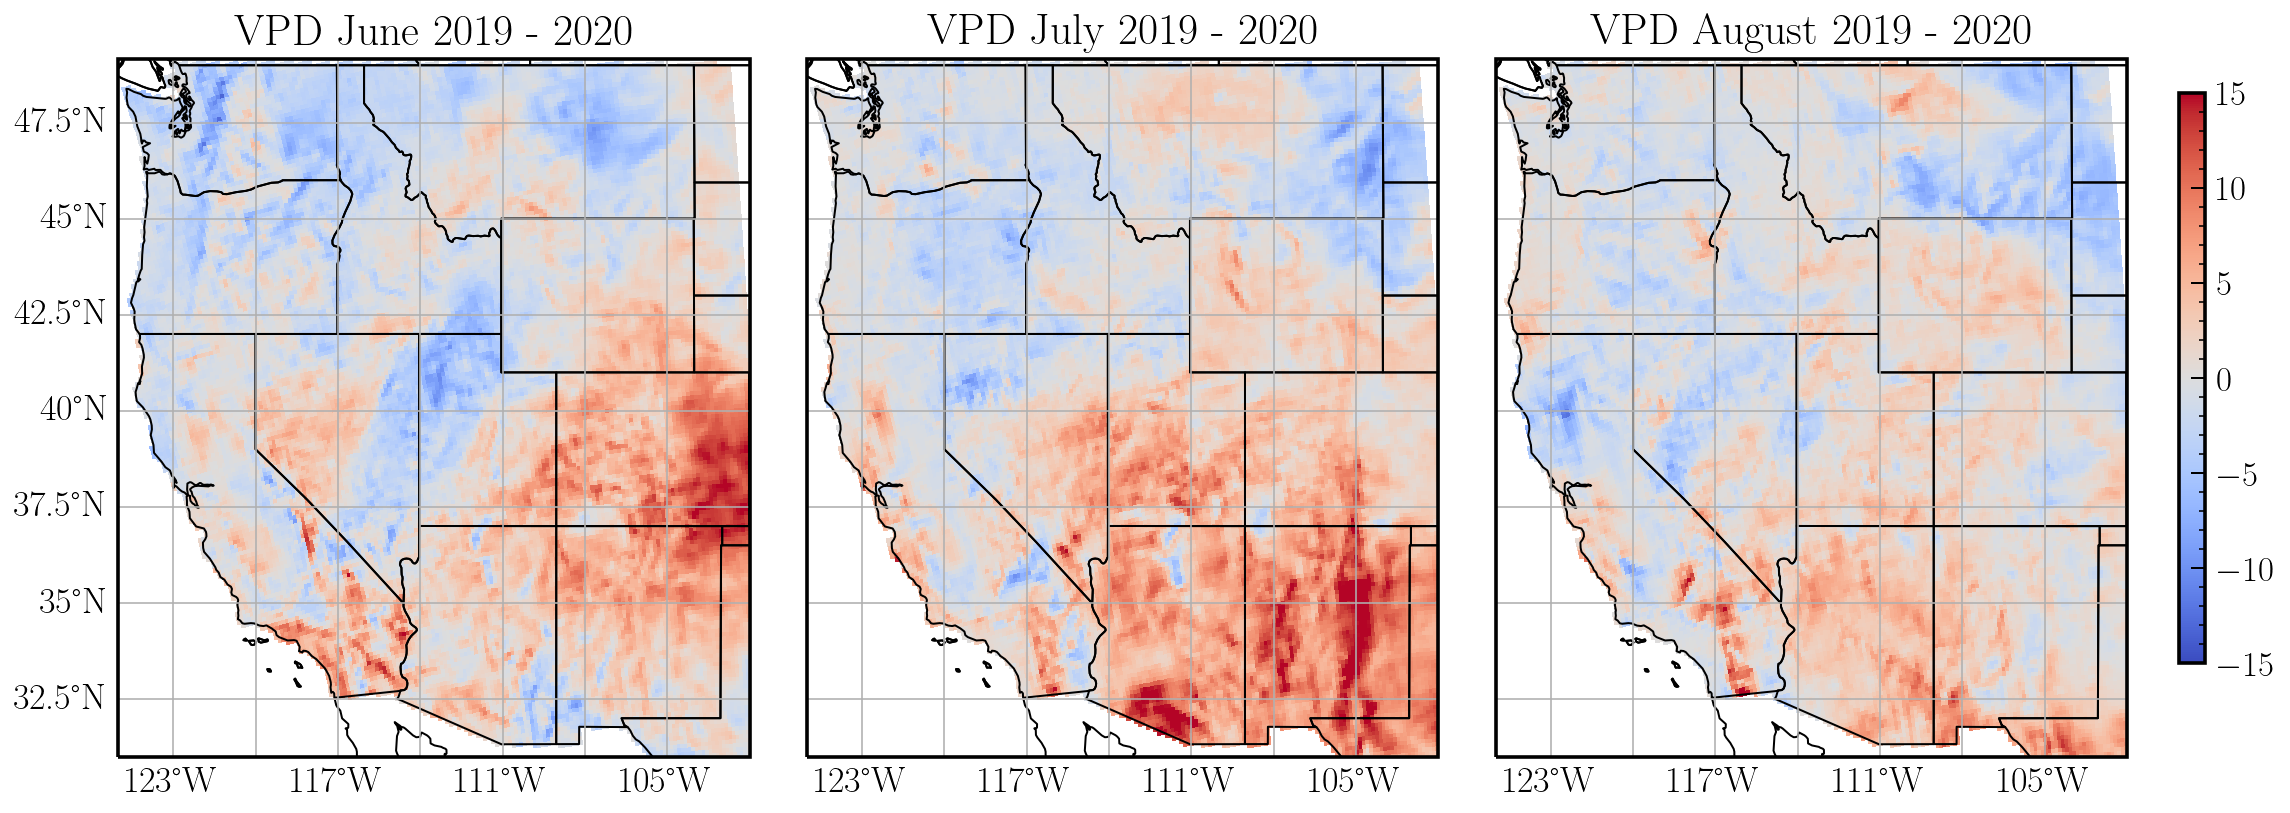

In [ ]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(4, 6)

ax= fig.add_subplot(gs[0:4, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');
CS= ax.pcolormesh(lat_long_grid[0], lat_long_fire_grid[1], ffwi_xarr.sel(time='2019-06-15') - ffwi_xarr.sel(time='2020-06-15').values, vmin= -15, vmax= 15, cmap=plt.cm.coolwarm) #.mean(axis= 0, skipna= False)  np.log10(pred_prob_xarr[0, : , :])
#cax= fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.1, ax.get_position().width, 0.02])
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1)
ax.set_title(r'VPD June 2019 - 2020', fontsize= 22);

ax1= fig.add_subplot(gs[0:4, 2:4], projection=ccrs.PlateCarree())
ax1.set_extent(extent);
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black');
CS1= ax1.pcolormesh(lat_long_grid[0], lat_long_fire_grid[1], ffwi_xarr.sel(time='2019-07-15') - ffwi_xarr.sel(time='2020-07-15').values, vmin= -15, vmax= 15, cmap=plt.cm.coolwarm) #.mean(axis= 0, skipna= False)
gl1= ax1.gridlines(draw_labels=True);
gl1.xlabel_style = {'size': 18, 'color': 'black'}
gl1.ylabel_style = {'size': 18, 'color': 'black'}
gl1.top_labels = False
gl1.left_labels = False
gl1.right_labels = False
ax1.set_aspect(1.4/1)
ax1.set_title(r'VPD July 2019 - 2020', fontsize= 22);

ax2= fig.add_subplot(gs[0:4, 4:6], projection=ccrs.PlateCarree())
ax2.set_extent(extent);
ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax2.add_feature(cfeature.STATES, edgecolor='black');
CS2= ax2.pcolormesh(lat_long_grid[0], lat_long_fire_grid[1], ffwi_xarr.sel(time='2019-08-15') - ffwi_xarr.sel(time='2020-08-15').values, vmin= -15, vmax= 15, cmap=plt.cm.coolwarm) #.mean(axis= 0, skipna= False)
cax= fig.add_axes([ax2.get_position().x1 + 0.02, ax2.get_position().y1 - 0.35, 0.01, ax2.get_position().height + 0.05])
cbar= fig.colorbar(CS2, cax= cax, orientation= 'vertical')
#cbar.set_label(r'Log fire probability', labelpad= 20, rotation= 270, fontsize= 18)
gl2= ax2.gridlines(draw_labels=True);
gl2.xlabel_style = {'size': 18, 'color': 'black'}
gl2.ylabel_style = {'size': 18, 'color': 'black'}
gl2.top_labels = False
gl2.left_labels = False
gl2.right_labels = False
ax2.set_aspect(1.4/1)
ax2.set_title(r'VPD August 2019 - 2020', fontsize= 22);
#plt.savefig('../plots/smlfire_output/pred_fire_prob_2022_obs.png', bbox_inches='tight', dpi= 200);

### Correlation between antecedent and fire month predictors

In [ ]:
# load in data frame with observed climate, vegetation, and human predictors

clim_df= pd.read_hdf('../data/clim_fire_freq_12km_w2022_data.h5') 
clim_df.loc[clim_df[clim_df.fire_freq > 1].index, 'fire_freq']= np.ones(len(clim_df[clim_df.fire_freq > 1].index), dtype= np.int64)

In [ ]:
jun_arr= np.arange(5, 465, 12)
may_arr= jun_arr - 1
jul_arr= jun_arr + 1
aug_arr= jun_arr + 2
summer_arr= np.sort(np.append(np.append(np.append(jun_arr, jul_arr), aug_arr), may_arr))

In [ ]:
ant_prec_corr_arr= []
ant_vpd_corr_arr= []
clim_df_groups= clim_df[clim_df.month.isin(summer_arr)].groupby(['X', 'Y'])
clim_df_keys= clim_df.dropna().groupby(['X', 'Y']).groups.keys()
for k in tqdm(clim_df_keys):
    ant_prec_corr_arr.append(stats.pearsonr(clim_df_groups.get_group(k)['Prec'], clim_df_groups.get_group(k)['Avgprec_3mo'])[0])
    ant_vpd_corr_arr.append(stats.pearsonr(clim_df_groups.get_group(k)['VPD'], clim_df_groups.get_group(k)['AvgVPD_3mo'])[0])

100%|██████████| 23903/23903 [00:25<00:00, 922.08it/s]


In [ ]:
np.mean(ant_prec_corr_arr), np.mean(ant_vpd_corr_arr)

(0.12658250133508814, 0.5732348407759681)

In [ ]:
clim_fire_df= pd.read_hdf('../data/clim_fire_size_12km_w2022_data.h5') 

In [ ]:
clim_fire_df_groups= clim_fire_df.drop_duplicates(subset= 'fire_indx').groupby(['grid_x', 'grid_y'])
clim_fire_df_keys= list(clim_fire_df.drop_duplicates(subset= 'fire_indx').groupby(['grid_x', 'grid_y']).groups.keys())
prec_df= pd.Series({})
ant_prec_df= pd.Series({})
vpd_df= pd.Series({})
ant_vpd_df= pd.Series({})

for k in tqdm(clim_fire_df_keys):
    prec_df= pd.concat([prec_df, clim_fire_df_groups.get_group(k)['Prec']])
    ant_prec_df= pd.concat([ant_prec_df, clim_fire_df_groups.get_group(k)['Avgprec_3mo']])
    vpd_df= pd.concat([vpd_df, clim_fire_df_groups.get_group(k)['VPD']])
    ant_vpd_df= pd.concat([ant_vpd_df, clim_fire_df_groups.get_group(k)['AvgVPD_3mo']])
ant_fire_prec_corr_arr= stats.pearsonr(prec_df.values, ant_prec_df.values)[0]
ant_fire_vpd_corr_arr= stats.pearsonr(vpd_df.values, ant_vpd_df.values)[0]

100%|██████████| 9648/9648 [00:04<00:00, 2134.90it/s]


In [ ]:
ant_fire_prec_corr_arr, ant_fire_vpd_corr_arr

(0.09408614764088513, 0.5373033958640666)